[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Fri Feb 21 08:30:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-02-21 08:33:26--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-02-21 08:33:26 (86.4 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


100%|██████████| 51.2M/51.2M [00:00<00:00, 242MB/s]


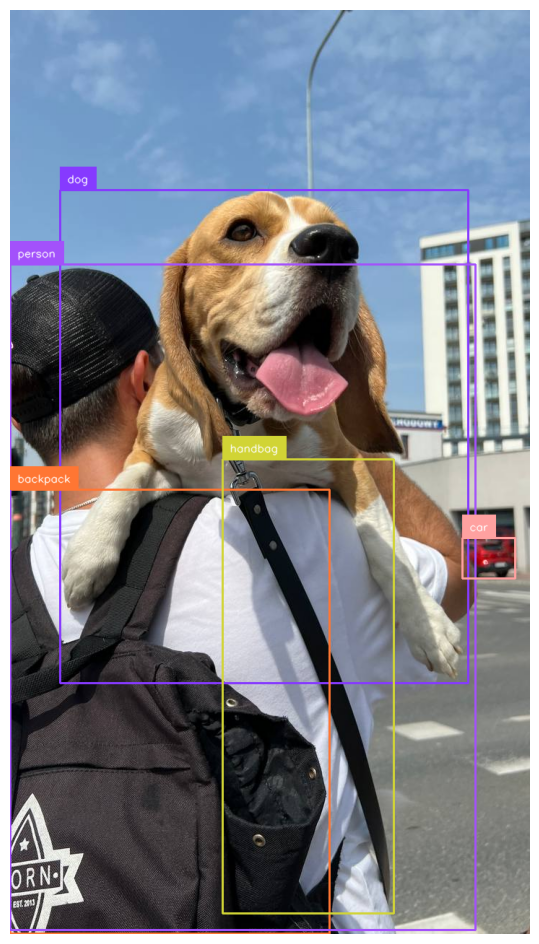

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [7]:
from roboflow import download_dataset

dataset = download_dataset('https://universe.roboflow.com/roboflow-100/circuit-voltages/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to circuit-voltages-2 in yolov8:: 100%|██████████| 276/276 [00:00<00:00, 5849.62it/s]


In [8]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0TCR3AhPyWODXV3CuAer")
project = rf.workspace("human-b7vnx").project("thermal_img_detection")
version = project.version(3)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Thermal_img_detection-3 in yolov12:: 100%|██████████| 6522/6522 [00:02<00:00, 2559.42it/s]


In [9]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [11]:
!cat {dataset.location}/data.yaml

train: /content/Thermal_img_detection-2/train/images
val: /content/Thermal_img_detection-2/valid/images
test: /content/Thermal_img_detection-2/test/images

nc: 3
names: 
  - car
  - dog
  - person

roboflow:
  workspace: human-b7vnx
  project: thermal_img_detection
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/human-b7vnx/thermal_img_detection/dataset/2


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [15]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data='/content/Thermal_img_detection-3/data.yaml', epochs=50)


New https://pypi.org/project/ultralytics/8.3.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Thermal_img_detection-3/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

100%|██████████| 755k/755k [00:00<00:00, 9.67MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689920  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.34M/5.34M [00:00<00:00, 68.1MB/s]


AMP: checks passed ✅


train: Scanning /content/Thermal_img_detection-3/train/labels... 2281 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2281/2281 [00:01<00:00, 1732.73it/s]

train: WARNING ⚠️ /content/Thermal_img_detection-3/train/images/FLIR_05639_jpeg-1-_jpg.rf.7f1d3d11fccc8f244603b0607618db37.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Thermal_img_detection-3/train/images/FLIR_07226_jpeg-1-_jpg.rf.9474a4d61665b01b64b167b38544cdf9.jpg: 1 duplicate labels removed
train: New cache created: /content/Thermal_img_detection-3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Thermal_img_detection-3/valid/labels... 650 images, 0 backgrounds, 0 corrupt: 100%|██████████| 650/650 [00:00<00:00, 739.68it/s]

val: New cache created: /content/Thermal_img_detection-3/valid/labels.cache


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/143 [00:00<?, ?it/s]Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at ../aten/src/ATen/native/transformers/cuda/attention_backward.cu:655.)
       1/50      5.36G      4.087      4.439      3.728         60        640: 100%|██████████| 143/143 [01:03<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.26it/s]

                   all        650       4473      0.354     0.0313    0.00877    0.00268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.44G      3.142      2.884      2.516         96        640: 100%|██████████| 143/143 [00:59<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]


                   all        650       4473      0.167      0.158      0.103     0.0352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.41G      2.661      2.295      2.098        120        640: 100%|██████████| 143/143 [00:58<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


                   all        650       4473      0.251       0.17      0.162     0.0627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.24G      2.454       2.02      1.911         80        640: 100%|██████████| 143/143 [00:58<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]


                   all        650       4473      0.607      0.215      0.201     0.0809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.37G      2.324      1.902      1.828         90        640: 100%|██████████| 143/143 [00:58<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.66it/s]


                   all        650       4473      0.682      0.239      0.266      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.41G      2.201      1.752      1.712         60        640: 100%|██████████| 143/143 [00:58<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


                   all        650       4473       0.66      0.239      0.247      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       5.4G      2.125      1.674      1.652         61        640: 100%|██████████| 143/143 [00:58<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]


                   all        650       4473        0.7       0.25      0.281      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.41G      2.059      1.591      1.611         87        640: 100%|██████████| 143/143 [00:57<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]


                   all        650       4473      0.728      0.299      0.342      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.25G      2.018      1.537      1.571         74        640: 100%|██████████| 143/143 [00:58<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


                   all        650       4473      0.759      0.308       0.36       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.24G       1.98      1.496      1.558         86        640: 100%|██████████| 143/143 [00:58<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.61it/s]


                   all        650       4473      0.761      0.312      0.372      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.17G      1.922      1.433      1.523         78        640: 100%|██████████| 143/143 [00:58<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.69it/s]


                   all        650       4473      0.421      0.331      0.376       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.24G      1.901        1.4      1.501        114        640: 100%|██████████| 143/143 [00:58<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]


                   all        650       4473      0.758      0.334      0.385       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.25G       1.87      1.358      1.467         75        640: 100%|██████████| 143/143 [00:57<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


                   all        650       4473      0.517      0.366      0.402      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       5.4G      1.872      1.344      1.466         73        640: 100%|██████████| 143/143 [00:57<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


                   all        650       4473      0.814      0.366      0.436      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.35G      1.845       1.32      1.455        136        640: 100%|██████████| 143/143 [00:57<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


                   all        650       4473      0.453      0.339      0.396      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.23G      1.811      1.275      1.424        110        640: 100%|██████████| 143/143 [00:58<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.62it/s]


                   all        650       4473      0.555      0.378      0.444      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.41G      1.807      1.269      1.411        104        640: 100%|██████████| 143/143 [00:58<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


                   all        650       4473      0.475      0.363      0.429      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.23G      1.778       1.25      1.411         63        640: 100%|██████████| 143/143 [00:58<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.66it/s]

                   all        650       4473      0.567      0.381      0.456      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.25G      1.759      1.228       1.39         69        640: 100%|██████████| 143/143 [00:57<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]


                   all        650       4473      0.569      0.388      0.453      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.28G       1.75      1.205      1.378        181        640: 100%|██████████| 143/143 [00:57<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]


                   all        650       4473      0.569      0.397       0.48      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.25G       1.74       1.19      1.382        109        640: 100%|██████████| 143/143 [00:57<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


                   all        650       4473      0.754      0.428      0.499      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       5.3G      1.709      1.165      1.358        116        640: 100%|██████████| 143/143 [00:57<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]


                   all        650       4473      0.848      0.384      0.465      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.37G      1.698      1.158      1.358         64        640: 100%|██████████| 143/143 [00:58<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.69it/s]


                   all        650       4473      0.704      0.407      0.492      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.27G      1.675      1.141      1.337         98        640: 100%|██████████| 143/143 [00:58<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]


                   all        650       4473      0.727      0.403      0.495      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.21G      1.654      1.119       1.33         92        640: 100%|██████████| 143/143 [00:58<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]

                   all        650       4473      0.713       0.43      0.521      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.46G      1.664      1.129      1.324         62        640: 100%|██████████| 143/143 [00:57<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


                   all        650       4473      0.849      0.432      0.521      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.26G      1.638        1.1      1.317         74        640: 100%|██████████| 143/143 [00:57<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


                   all        650       4473      0.739       0.43      0.525      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.43G      1.632      1.093      1.316         99        640: 100%|██████████| 143/143 [00:58<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]


                   all        650       4473      0.572      0.455      0.523      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.22G      1.637      1.088      1.315         72        640: 100%|██████████| 143/143 [00:58<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


                   all        650       4473      0.716      0.429      0.513      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.25G       1.63      1.081      1.304         69        640: 100%|██████████| 143/143 [00:59<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


                   all        650       4473      0.595      0.459      0.529      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.26G        1.6       1.07      1.303         38        640: 100%|██████████| 143/143 [00:58<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]

                   all        650       4473      0.735      0.438      0.537      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.46G      1.605      1.051      1.294         60        640: 100%|██████████| 143/143 [00:57<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]


                   all        650       4473      0.555      0.469      0.523      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.36G       1.61      1.047       1.29         86        640: 100%|██████████| 143/143 [00:57<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


                   all        650       4473      0.859      0.449      0.548      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       5.3G       1.58      1.034      1.287         84        640: 100%|██████████| 143/143 [00:58<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]


                   all        650       4473      0.855      0.448      0.551        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.23G      1.568      1.018      1.276        129        640: 100%|██████████| 143/143 [00:57<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


                   all        650       4473      0.682      0.446      0.549      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.26G      1.562      1.028      1.276         27        640: 100%|██████████| 143/143 [00:57<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.57it/s]


                   all        650       4473      0.611      0.514      0.559      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.44G      1.566      1.012      1.268        122        640: 100%|██████████| 143/143 [00:58<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


                   all        650       4473      0.715      0.448      0.539      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.29G      1.544          1      1.265        123        640: 100%|██████████| 143/143 [00:58<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]


                   all        650       4473      0.703      0.484      0.563      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.23G      1.545     0.9935       1.25         95        640: 100%|██████████| 143/143 [00:57<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]

                   all        650       4473      0.551      0.555      0.569      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.25G       1.53     0.9771      1.251         43        640: 100%|██████████| 143/143 [00:57<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]


                   all        650       4473      0.686      0.533      0.577      0.322
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.21G      1.503     0.9341      1.262         51        640: 100%|██████████| 143/143 [00:57<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


                   all        650       4473      0.677      0.517      0.574      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.28G      1.482     0.9194      1.254         46        640: 100%|██████████| 143/143 [00:56<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


                   all        650       4473      0.809      0.483      0.588      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.27G      1.467     0.9111      1.253         49        640: 100%|██████████| 143/143 [00:56<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


                   all        650       4473      0.793      0.492      0.595      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.28G      1.471     0.9069      1.246         79        640: 100%|██████████| 143/143 [00:56<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]


                   all        650       4473      0.609      0.565      0.579      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.21G      1.461      0.899      1.241         74        640: 100%|██████████| 143/143 [00:56<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]


                   all        650       4473      0.794      0.542      0.613      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.27G      1.458     0.8889      1.242         58        640: 100%|██████████| 143/143 [00:56<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]


                   all        650       4473      0.741      0.534      0.618      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.22G      1.441     0.8774      1.229         58        640: 100%|██████████| 143/143 [00:57<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.59it/s]


                   all        650       4473      0.735      0.536      0.624      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.26G      1.443     0.8759      1.231        130        640: 100%|██████████| 143/143 [00:59<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


                   all        650       4473      0.801      0.526      0.617      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.23G      1.424     0.8661      1.219         62        640: 100%|██████████| 143/143 [00:57<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.69it/s]


                   all        650       4473      0.708      0.544      0.606      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.27G      1.431     0.8692      1.227         45        640: 100%|██████████| 143/143 [00:56<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.60it/s]

                   all        650       4473      0.698       0.53      0.605      0.342



50 epochs completed in 0.943 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 18.9MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 18.9MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 352 layers, 9,232,041 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


                   all        650       4473      0.736      0.536      0.623      0.345
                   car        465       2496      0.826      0.679      0.804      0.497
                   dog         29         29      0.575      0.241       0.27      0.121
                person        594       1948      0.806      0.687      0.796      0.418
Speed: 0.3ms preprocess, 7.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train4


## Evaluate fine-tuned YOLOv12 model

In [16]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml  weights


In [18]:
from IPython.display import Image

Image(filename=f'/content/runs', width=1000)

ValueError: Cannot embed the '/content/runs' image format

In [19]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/train/results.png'

In [20]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['car', 'dog', 'person']

In [21]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

FileNotFoundError: [Errno 2] No such file or directory: '//content/runs/detect/train/weights/best.pt'

In [22]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

AttributeError: type object 'map' has no attribute 'map50_95'

In [23]:
map.plot()

AttributeError: type object 'map' has no attribute 'plot'

## Run inference with fine-tuned YOLOv12 model

In [24]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

FileNotFoundError: [Errno 2] No such file or directory: '//content/runs/detect/train/weights/best.pt'

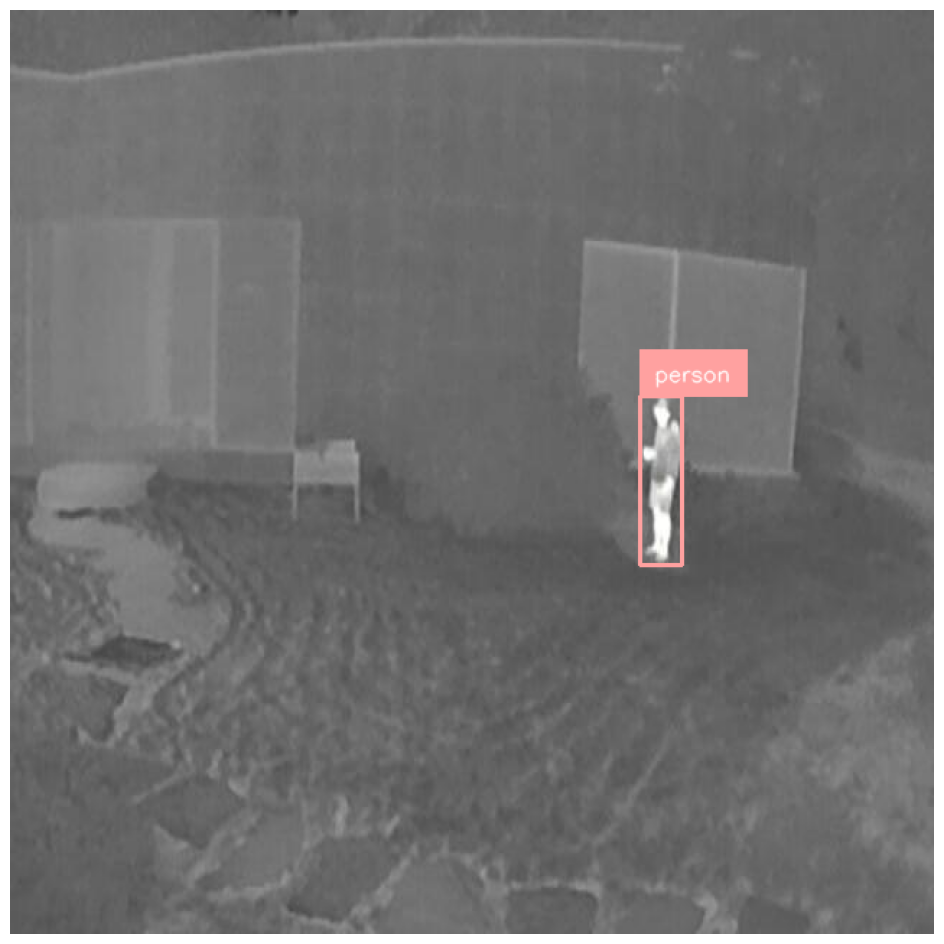

In [25]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)